In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from scipy.signal import argrelextrema

In [ ]:
def fetch_stock_data(ticker, start="2020-01-01", end="2024-01-01"):
    data = yf.download(ticker, start=start, end=end)
    return data  # full DataFrame for more insights

ticker = "AAPL"  # Apple stock
data = fetch_stock_data(ticker)
prices = data["Close"].values  # Closing prices zt end of day

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


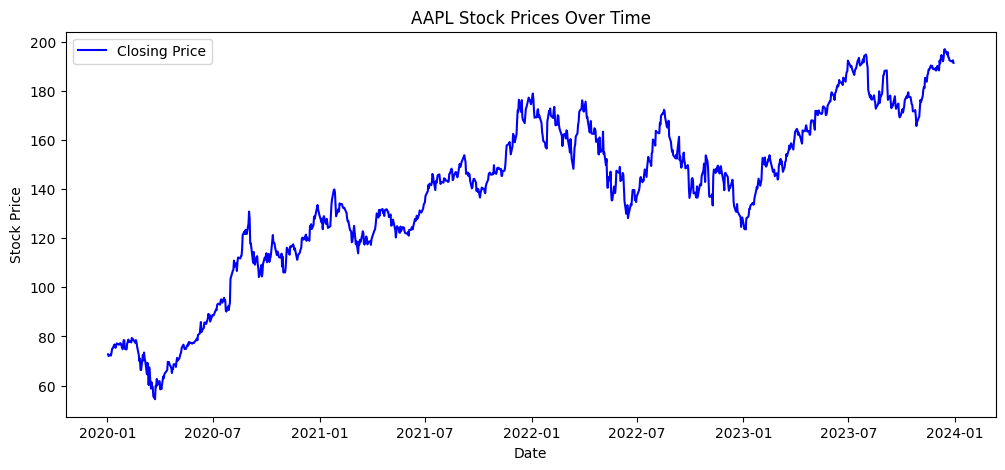

In [ ]:
# stock price vs date
plt.figure(figsize=(12, 5))
plt.plot(data.index, prices, label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} Stock Prices Over Time")
plt.legend()
plt.show()

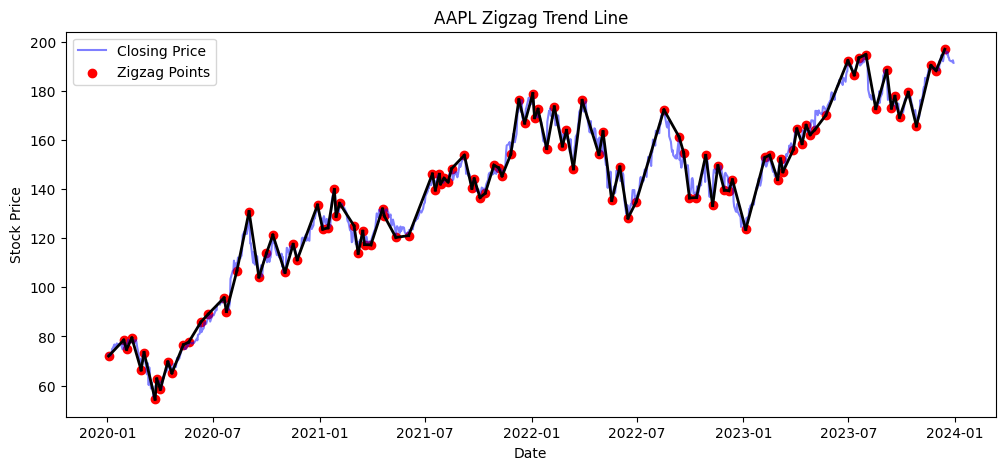

In [ ]:
# Zigzag Indicator: Finds peaks & valleys
def zigzag_indicator(prices, order=5):
    peaks = argrelextrema(prices, np.greater, order=order)[0]
    valleys = argrelextrema(prices, np.less, order=order)[0]

    # Combine & sort peaks and valleys chronologically
    zigzag_points = np.sort(np.concatenate((peaks, valleys)))
    return zigzag_points

zigzag_points = zigzag_indicator(prices)

# Plot Zigzag Indicator
plt.figure(figsize=(12, 5))
plt.plot(data.index, prices, label="Closing Price", color="blue", alpha=0.5)
plt.scatter(data.index[zigzag_points], prices[zigzag_points], color="red", label="Zigzag Points", marker="o")

# **NEW: Draw proper straight-line Zigzag Trend**
for i in range(len(zigzag_points) - 1):
    x1, x2 = data.index[zigzag_points[i]], data.index[zigzag_points[i + 1]]
    y1, y2 = prices[zigzag_points[i]], prices[zigzag_points[i + 1]]
    plt.plot([x1, x2], [y1, y2], color="black", linewidth=2)  # Straight-line connection

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} Zigzag Trend Line")
plt.legend()
plt.show()


In [ ]:
def min_max_scaling(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val), min_val, max_val

scaled_prices, min_price, max_price = min_max_scaling(prices)

In [ ]:
split_ratio = 0.8
split_index = int(len(scaled_prices) * split_ratio)
train_data, test_data = scaled_prices[:split_index], scaled_prices[split_index:]

In [ ]:
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 100  # Use past 10 days to predict next
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM input (batch, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
class AdamOptimizer:
    def __init__(self, shape, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = np.zeros(shape)
        self.v = np.zeros(shape)
        self.t = 0

    def update(self, grad):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        return -self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

In [ ]:
class LSTM:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001, dropout_rate=0.2):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate

        # Initialize weights with Xavier initialization
        self.Wf = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))
        self.Wi = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))
        self.Wo = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))
        self.Wc = np.random.randn(hidden_dim, hidden_dim + input_dim) * np.sqrt(2 / (hidden_dim + input_dim))

        self.Wy = np.random.randn(output_dim, hidden_dim) * np.sqrt(2 / hidden_dim)

        self.bf = np.zeros((hidden_dim, 1))
        self.bi = np.zeros((hidden_dim, 1))
        self.bo = np.zeros((hidden_dim, 1))
        self.bc = np.zeros((hidden_dim, 1))
        self.by = np.zeros((output_dim, 1))

        self.optimizers = {
            "Wf": AdamOptimizer(self.Wf.shape, lr=learning_rate),
            "Wi": AdamOptimizer(self.Wi.shape, lr=learning_rate),
            "Wo": AdamOptimizer(self.Wo.shape, lr=learning_rate),
            "Wc": AdamOptimizer(self.Wc.shape, lr=learning_rate),
            "Wy": AdamOptimizer(self.Wy.shape, lr=learning_rate)
        }

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def dropout(self, x):
        mask = (np.random.rand(*x.shape) > self.dropout_rate) / (1.0 - self.dropout_rate)
        return x * mask

    def forward(self, x, h_prev, c_prev, training=True):
        concat = np.vstack((h_prev, x))  # shape = (hidden_dim + input_dim, 1)

        ft = self.sigmoid(np.dot(self.Wf, concat) + self.bf)
        it = self.sigmoid(np.dot(self.Wi, concat) + self.bi)
        c_tilde = self.tanh(np.dot(self.Wc, concat) + self.bc)
        c_next = ft * c_prev + it * c_tilde
        ot = self.sigmoid(np.dot(self.Wo, concat) + self.bo)
        h_next = ot * self.tanh(c_next)

        # Apply dropout during training only
        if training:
            h_next = self.dropout(h_next)

        y_hat = np.dot(self.Wy, h_next) + self.by
        return y_hat, h_next, c_next

    def backward(self, x_t, y_true, h_prev, c_prev, y_pred):
        dWy = np.dot((y_pred - y_true), h_prev.T)  # Shape (1, 50)
        dby = np.sum(y_pred - y_true, axis=1, keepdims=True)  # Ensure shape (1,1)

        # # Debug: Print shapes to verify correctness
        # print(f"dWy shape: {dWy.shape}, dby shape: {dby.shape}")

        dy = np.dot(self.Wy.T, (y_pred - y_true))  # Backprop through output layer
        do = dy * np.tanh(c_prev) * (h_prev * (1 - h_prev))  # Correct sigmoid derivative
        dc = dy * h_prev * (1 - np.tanh(c_prev) ** 2)  # Correct tanh derivative

        # Compute updates using Adam Optimizer
        self.Wy += self.optimizers["Wy"].update(dWy)

        # Fix: Ensure `by` has its own optimizer
        if "by" not in self.optimizers:
            self.optimizers["by"] = AdamOptimizer(self.by.shape, lr=self.learning_rate)

        self.by += self.optimizers["by"].update(dby)  # Use correct optimizer for `by`

        return dWy, dby, dc, do



    def train(self, X_train, y_train, epochs=10):
        for epoch in range(epochs):
            total_loss = 0
            h_prev = np.zeros((self.hidden_dim, 1))
            c_prev = np.zeros((self.hidden_dim, 1))

            for i in range(len(X_train)):
                x_seq = X_train[i].reshape(-1, 1)
                y_true = y_train[i].reshape(self.output_dim, 1)

                h_t, c_t = h_prev, c_prev  # Store last hidden/cell state

                for t in range(x_seq.shape[0]):
                    x_t = x_seq[t].reshape(self.input_dim, 1)
                    y_pred, h_t, c_t = self.forward(x_t, h_t, c_t)

                loss = np.mean((y_pred - y_true) ** 2)
                total_loss += loss

                # Backpropagate
                self.backward(x_t, y_true, h_t, c_t, y_pred)

            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.6f}")



In [ ]:
lstm = LSTM(input_dim=1, hidden_dim=128, output_dim=1, learning_rate=0.001, dropout_rate=0.3)
lstm.train(X_train, y_train, epochs=300)

Epoch 1/300, Loss: 7.795326
Epoch 2/300, Loss: 3.366140
Epoch 3/300, Loss: 2.911655
Epoch 4/300, Loss: 2.326901
Epoch 5/300, Loss: 2.341883
Epoch 6/300, Loss: 2.116960
Epoch 7/300, Loss: 1.956694
Epoch 8/300, Loss: 2.005403
Epoch 9/300, Loss: 1.710030
Epoch 10/300, Loss: 1.928675
Epoch 11/300, Loss: 1.929727
Epoch 12/300, Loss: 2.048810
Epoch 13/300, Loss: 1.981370
Epoch 14/300, Loss: 1.906451
Epoch 15/300, Loss: 1.873591
Epoch 16/300, Loss: 2.058623
Epoch 17/300, Loss: 1.942437
Epoch 18/300, Loss: 1.971493
Epoch 19/300, Loss: 1.918420
Epoch 20/300, Loss: 1.993194
Epoch 21/300, Loss: 1.836949
Epoch 22/300, Loss: 1.812840
Epoch 23/300, Loss: 1.834618
Epoch 24/300, Loss: 1.943695
Epoch 25/300, Loss: 1.842861
Epoch 26/300, Loss: 1.993860
Epoch 27/300, Loss: 1.989757
Epoch 28/300, Loss: 2.027361
Epoch 29/300, Loss: 1.802021
Epoch 30/300, Loss: 2.002512
Epoch 31/300, Loss: 1.892530
Epoch 32/300, Loss: 1.978557
Epoch 33/300, Loss: 1.915807
Epoch 34/300, Loss: 2.080103
Epoch 35/300, Loss: 1.9

In [ ]:
def predict(lstm, X_test):
    h_prev = np.zeros((lstm.hidden_dim, 1))
    c_prev = np.zeros((lstm.hidden_dim, 1))
    predictions = []

    for i in range(len(X_test)):
        x_seq = X_test[i].reshape(-1, 1)  # Shape = (seq_length, 1)

        # Use only the last timestep as input
        x_last = x_seq[-1].reshape(1, 1)  # Shape = (1, 1)

        y_pred, h_prev, c_prev = lstm.forward(x_last, h_prev, c_prev)  # Use last timestep

        predictions.append(y_pred.flatten()[0])

    return np.array(predictions)

# Predict on test set
y_pred_scaled = predict(lstm, X_test)

# Convert back to original scale
y_pred = y_pred_scaled * (max_price - min_price) + min_price
y_test_actual = y_test * (max_price - min_price) + min_price


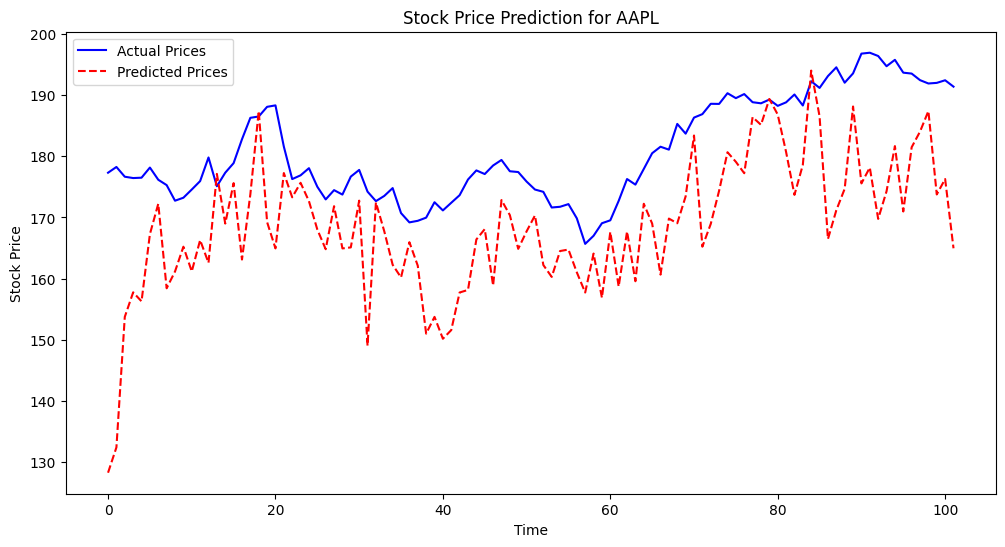

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color="blue")
plt.plot(y_pred, label="Predicted Prices", linestyle="dashed", color="red")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title(f"Stock Price Prediction for {ticker}")
plt.legend()
plt.show()

In [ ]:
# Extract corresponding dates for test set
test_dates = data.index[split_index + seq_length:]  # Align with `y_test`

# Flatten the arrays to 1D
y_test_actual_flat = y_test_actual.flatten()
y_pred_flat = y_pred.flatten()

# Create DataFrame
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': y_test_actual_flat,
    'Predicted Price': y_pred_flat
})

# Display the table
print(results_df)


          Date  Actual Price  Predicted Price
0   2023-08-07    177.309250       128.262404
1   2023-08-08    178.251083       132.413391
2   2023-08-09    176.654953       153.745196
3   2023-08-10    176.436844       157.755368
4   2023-08-11    176.496384       156.276339
..         ...           ...              ...
97  2023-12-22    192.444595       184.033034
98  2023-12-26    191.897873       187.391677
99  2023-12-27    191.997269       173.755589
100 2023-12-28    192.424713       176.279846
101 2023-12-29    191.380981       164.955870

[102 rows x 3 columns]
